In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
import torch
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel
from diffusers import EulerDiscreteScheduler
from diffusers import DDIMScheduler

In [3]:
from PIL import Image
import torch
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel
from diffusers import EulerDiscreteScheduler
from diffusers import DDIMScheduler

dtype = torch.float32
device = torch.device("cuda")

vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae", use_safetensors=True)
tokenizer = CLIPTokenizer.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="tokenizer")
text_encoder = CLIPTextModel.from_pretrained(
    "CompVis/stable-diffusion-v1-4", subfolder="text_encoder", use_safetensors=True
)
unet = UNet2DConditionModel.from_pretrained(
    "CompVis/stable-diffusion-v1-4", subfolder="unet", use_safetensors=True
)

torch_device = torch.device('cuda')
vae.to(torch_device)
text_encoder.to(torch_device)
unet.to(torch_device)



scheduler_euler = EulerDiscreteScheduler.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="scheduler")
scheduler = DDIMScheduler.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="scheduler")



def get_image(latents, nrow, ncol):
    image = vae.decode(latents / vae.config.scaling_factor, return_dict=False)[0]
    image = (image / 2 + 0.5).clamp(0, 1).squeeze()
    image = (image.permute(0, 2, 3, 1) * 255).to(torch.uint8)
    rows = []
    for row_i in range(nrow):
        row = []
        for col_i in range(ncol):
            i = row_i*nrow + col_i
            row.append(image[i])
        rows.append(torch.hstack(row))
    image = torch.vstack(rows)
    return Image.fromarray(image.cpu().numpy())


def get_text_embedding(prompt):
    text_input = tokenizer(
        prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt"
    )
    return text_encoder(text_input.input_ids.to(torch_device))[0]



100%|██████████| 10/10 [00:02<00:00,  4.14it/s]


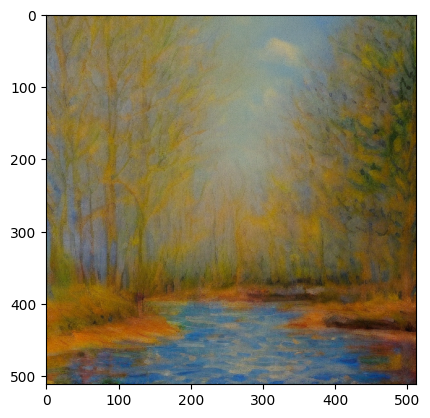

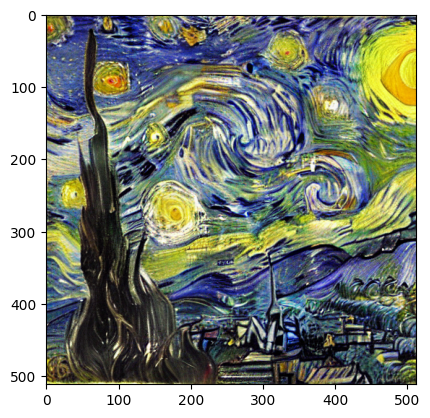

In [4]:
from tqdm.auto import tqdm

def sample_loop(prompts, num_inference_steps=10, guidance_scale=7.5, generator_seed=None):

    # Set generator seed if provided
    generator = None
    if generator_seed is not None:
        generator = torch.Generator(device=torch_device).manual_seed(generator_seed)

    with torch.no_grad():
        # Get text embeddings
        text_embeddings = []
        for prompt in prompts:
            text_embeddings.append(get_text_embedding(prompt))
        text_embeddings = torch.cat(text_embeddings)
        
        # Get unconditional embeddings for classifier free guidance
        uncond_embeddings = get_text_embedding([""] * len(prompts))
        
        # Prepare scheduler
        scheduler.set_timesteps(num_inference_steps)
        
        # Prepare latents
        latents = torch.randn(
            (len(prompts), unet.config.in_channels, 64, 64),
            device=torch_device,
            dtype=torch.float32,
            generator=generator
        )
        latents = latents * scheduler.init_noise_sigma
        
        # Sampling loop
        progress_bar = tqdm(total=len(scheduler.timesteps))
        for t in scheduler.timesteps:
            # Expand latents for classifier free guidance
            latent_model_input = torch.cat([latents] * 2)
            
            # Get model prediction
            noise_pred = unet(
                latent_model_input,
                t,
                encoder_hidden_states=torch.cat([uncond_embeddings, text_embeddings])
            ).sample


            
            # Perform guidance
            noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)

            noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)
            
            # Compute previous noisy sample
            latents = scheduler.step(noise_pred, t, latents).prev_sample
            
            progress_bar.update(1)
        progress_bar.close()
        
        # Decode latents to image
        # Decode latents to image using VAE
        latents = latents / vae.config.scaling_factor
        image = vae.decode(latents, return_dict=False)[0]
        
        # Normalize image to [0,1] range
        image = (image / 2 + 0.5).clamp(0, 1)
        
        # Convert to uint8 format
        image = (image.permute(0, 2, 3, 1) * 255).to(torch.uint8)
        
    return image


image = sample_loop(["impressionist painting", "van gogh painting"])

plt.imshow(image.cpu().numpy()[0])
plt.show()

plt.imshow(image.cpu().numpy()[1])
plt.show()


100%|██████████| 10/10 [00:03<00:00,  3.06it/s]


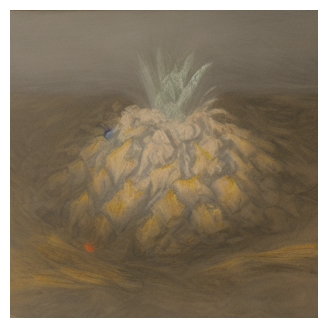

In [5]:
def sample_loop_product(prompts, num_inference_steps=10, guidance_scale=15.0, return_type = "image", mu = None, generator_seed=None):

    if mu is None:
        mu = torch.ones(len(prompts), device=torch_device)/len(prompts)

    # Set generator seed if provided
    generator = None
    if generator_seed is not None:
        generator = torch.Generator(device=torch_device).manual_seed(generator_seed)

    with torch.no_grad():
        # Get text embeddings
        text_embeddings = []
        for prompt in prompts:
            text_embeddings.append(get_text_embedding(prompt))
        text_embeddings = torch.cat(text_embeddings)
        
        # Get unconditional embeddings for classifier free guidance
        uncond_embeddings = get_text_embedding([""])
        
        # Prepare scheduler
        scheduler.set_timesteps(num_inference_steps)
        
        # Prepare latents
        latents = torch.randn(
            (1, unet.config.in_channels, 64, 64),
            device=torch_device,
            dtype=torch.float32,
            generator=generator
        )
        latents = latents * scheduler.init_noise_sigma
        
        # Sampling loop
        progress_bar = tqdm(total=len(scheduler.timesteps))
        for t in scheduler.timesteps:
            # Expand latents for classifier free guidance
            latent_model_input = latents
            
            # Get model prediction
            noise_pred_uncond = unet(
                latent_model_input,
                t,
                encoder_hidden_states=uncond_embeddings
            ).sample


            latent_model_input = torch.cat([latents] * 2)
            
            noise_preds_text = []
            noise_preds_uncond = []

            for i,prompt in enumerate(prompts):

                noise_pred = unet(
                    latent_model_input,
                    t,
                    encoder_hidden_states=torch.cat([uncond_embeddings, text_embeddings[i].unsqueeze(0)])
                ).sample
                noise_preds_text.append(noise_pred.chunk(2)[1])
                noise_preds_uncond.append(noise_pred.chunk(2)[0])

                # print("uncond", F.mse_loss(noise_pred_uncond, noise_preds_uncond[i]))
                # print("text", F.mse_loss(noise_preds_text[i], noise_preds_uncond[i]))
            


            # Perform guidance
            noise_pred = noise_pred_uncond

            for i in range(len(prompts)):
                noise_pred += mu[i] * guidance_scale * (noise_preds_text[i] - noise_preds_uncond[i])

            # Compute previous noisy sample
            latents = scheduler.step(noise_pred, t, latents).prev_sample
            
            progress_bar.update(1)
        progress_bar.close()
        
        # Decode latents to image
        # Decode latents to image using VAE
        latents = latents / vae.config.scaling_factor
        image = vae.decode(latents, return_dict=False)[0]
        
        # Normalize image to [0,1] range
        image = (image / 2 + 0.5).clamp(0, 1)
        
        # Convert to uint8 format
        image = (image.permute(0, 2, 3, 1) * 255).to(torch.uint8)
    if return_type == "image":
        return image
    elif return_type == "latents":
        return latents
    elif return_type == "all":
        return image, latents


seed = 42
num_inference_steps = 10

w = 1/2


image = sample_loop_product(
    ["a pinapple", "a volcano"],
    return_type="image",
    guidance_scale=7.5,
    mu=torch.tensor([w, w]),
    num_inference_steps=num_inference_steps,
    generator_seed=seed  # Added for reproducibility
)



pil_image = Image.fromarray(image[0].cpu().numpy())
plt.figure(figsize=(4,4))
plt.imshow(pil_image)
plt.axis('off')
plt.show()

In [ ]:
seed = 42
num_inference_steps = 10
w = 1.0

for i in range(5):

    image = sample_loop_product(
        ["portrait of a medieval knight", "helmet", "painting"],
        return_type="image",
        guidance_scale=7.5,
        mu=torch.tensor([1.0, -1.0, -1.0]),
        num_inference_steps=num_inference_steps,
    )
    plt.imshow(image.cpu().numpy()[0])
    plt.show()

In [6]:
import torch.nn.functional as F

def compute_KL(init_latents, prompts, scheduler, unet, vae, num_inference_steps=10, guidance_scale=7.5, mu = None):
    
    # if mu is None:
    #     mu = torch.ones(len(prompts), device=torch_device)

    with torch.no_grad():
        # Get text embeddings
        text_embeddings = []
        for prompt in prompts:
            text_embeddings.append(get_text_embedding(prompt))
        text_embeddings = torch.cat(text_embeddings)
        
        # Get unconditional embeddings for classifier free guidance
        uncond_embeddings = get_text_embedding([""])
        
        # Prepare scheduler
        scheduler.set_timesteps(num_inference_steps)
        
        latents = init_latents
        noise = torch.randn_like(latents)

        kls = torch.zeros(len(prompts), device=torch_device)


        # Sampling loop
        progress_bar = tqdm(total=len(scheduler.timesteps))
        for t in scheduler.timesteps:
            # print(t)
            # Expand latents for classifier free guidance
            # Compute previous noisy sample
            latents = scheduler.add_noise(init_latents, noise, t)
            latent_model_input = latents

            
            # Get model prediction
            noise_pred_uncond = unet(
                latent_model_input,
                t,
                encoder_hidden_states=uncond_embeddings
            ).sample


            latent_model_input = torch.cat([latents] * 2)
            
            noise_preds_text = []
            noise_preds_uncond = []

            for i,prompt in enumerate(prompts):

                noise_pred_cond = unet(
                    latent_model_input,
                    t,
                    encoder_hidden_states=torch.cat([uncond_embeddings, text_embeddings[i].unsqueeze(0)])
                ).sample
                noise_preds_text.append(noise_pred_cond.chunk(2)[1])
                noise_preds_uncond.append(noise_pred_cond.chunk(2)[0])

            
            # Perform guidance
            # noise_pred = noise_pred_uncond.clone()
            noise_pred = 0.0*noise_pred_uncond.clone()

            

            for i in range(len(prompts)):
                noise_pred += mu[i] * guidance_scale * (noise_preds_text[i] - noise_preds_uncond[i])

            

            for i in range(len(prompts)):
                #this will trivially give mu* = 0.5
                # kls[i] += F.mse_loss(noise_pred_uncond + guidance_scale * (noise_preds_text[i] - noise_preds_uncond[i]), noise_pred)
                
                #this seems to give a correct signal
                # kls[i] += F.mse_loss(guidance_scale * (noise_preds_text[i] - noise_preds_uncond[i]), noise_pred)

                kls[i] += F.mse_loss((noise_preds_text[i] - noise_preds_uncond[i]), noise_pred)

            
            progress_bar.update(1)
        progress_bar.close()

    return kls
        

In [31]:
def project_onto_simplex(x: torch.Tensor) -> torch.Tensor:
    """
    Projects a 1D tensor x onto the simplex:
       { u : u[i] >= 0, sum_i u[i] = 1 }.
    """
    # Sort x in descending order
    sorted_x, sorted_indices = torch.sort(x, descending=True)

    # Accumulate the sorted values
    cssv = torch.cumsum(sorted_x, dim=0)

    # Identify the smallest k such that sorted_x[k] - (cssv[k] - 1) / (k+1) > 0
    # (Note: we shift by one because of 0-based indexing)
    rhos = sorted_x - (1.0 / torch.arange(1, x.numel() + 1, device=x.device)) * (cssv - 1)
    rho = torch.nonzero(rhos > 0, as_tuple=True)[0][-1]

    # The threshold to subtract
    theta = (cssv[rho] - 1.0) / (rho + 1.0)

    # Re-project and clamp to zero
    return torch.clamp(x - theta, min=0)

def dual_step(lr_dual, KLs, mu, b = None):

    l = torch.tensor(KLs, requires_grad = False).to(mu.device)
    if b is None:
        b = torch.zeros_like(mu)
    b = b.to(mu.device)
    grad = -lr_dual*(l - b)

    mu = (mu + grad).detach()
    
    for i in range(mu.shape[0]):
        if mu[i] < 0:
            mu[i] = 0

    # mu = project_onto_simplex(mu)

    return mu



In [ ]:
#MAIN CODE: TRAINING + VALIDATION (3 prompts)

from PIL import Image
import matplotlib.pyplot as plt
from transformers import CLIPModel, CLIPProcessor
import numpy as np
import torch
from accelerate import Accelerator
import os
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel
from diffusers import EulerDiscreteScheduler
from diffusers import DDIMScheduler
from tqdm.auto import tqdm
import numpy as np
import torch.nn.functional as F
import wandb
from PIL import Image
import matplotlib.pyplot as plt
from transformers import CLIPModel, CLIPProcessor
import numpy as np
import torch
from accelerate import Accelerator
import os
import argparse
import sys
import random
from transformers import AutoProcessor, Blip2ForImageTextRetrieval


# Initialize accelerator with multi-GPU support
accelerator = Accelerator(split_batches=True)
device = accelerator.device

# Set environment variables for multi-GPU training
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"

num_runs = 1
num_epochs = 200
lr_dual = 0.1
num_inference_steps = 10
b = 12*torch.ones(2, device=device)

train_guidance_scale = 100.0
val_guidance_scale = 7.5

val_epochs = 2
num_images = 200
use_wandb = True # Flag to control wandb logging


clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

model = Blip2ForImageTextRetrieval.from_pretrained("Salesforce/blip2-itm-vit-g").to(device)
processor = AutoProcessor.from_pretrained("Salesforce/blip2-itm-vit-g")


# Set random seeds for reproducibility
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

main_prompt = "a portrait of a medieval knight"
erase_prompt_1 = "helmet" 
erase_prompt_2 = "a painting"

prompts = [main_prompt, erase_prompt_1, erase_prompt_2]

mu = torch.zeros(len(prompts), device=device)
mu[0] = 1.0

print(f"Running job with main_prompt={main_prompt}, erase_prompt_1={erase_prompt_1}, erase_prompt_2={erase_prompt_2}")

if use_wandb:
    import wandb
    wandb.init(project="unlearning_three_prompts")

    # Log configuration parameters
    wandb.config.update({
        "train_guidance_scale": train_guidance_scale,
        "val_guidance_scale": val_guidance_scale,
        "num_epochs": num_epochs,
        "lr_dual": lr_dual,
        "initial_mu": mu.tolist(),
        "prompts": prompts,
        "num_inference_steps": num_inference_steps,
        "num_gpus": torch.cuda.device_count(),
        "b": b.tolist()
    })

# Prepare models for distributed training
unet, vae, scheduler = accelerator.prepare(unet, vae, scheduler)

for epoch in range(num_epochs):

    with torch.no_grad():

        w = mu.clone()
        w[1:] = -w[1:]

        images, lats = sample_loop_product(prompts, mu = w, return_type = "all", num_inference_steps=num_inference_steps, guidance_scale=7.5)
        kls = compute_KL(lats, prompts, scheduler, unet, vae, num_inference_steps=num_inference_steps, mu = w, guidance_scale=train_guidance_scale)

        # Gather results from all processes
        images = accelerator.gather(images)
        kls = accelerator.gather(kls)
        mu = accelerator.gather(mu)

        print(f"Device: {accelerator.device}, Local Rank: {accelerator.local_process_index}, mu: {mu}")

        if accelerator.is_main_process:
            image_np = images[0].cpu().numpy()

            if use_wandb:
                wandb.log({
                    f"image": wandb.Image(image_np),
                }, step=epoch)

                for i in range(len(prompts)):
                    wandb.log({
                        f"kl_{prompts[i]}": kls[i].item(),
                        f"mu_{prompts[i]}": mu[i].item(),
                    }, step=epoch)

        mu[1:] = dual_step(lr_dual, kls[1:], mu[1:], b)

        #computing clip/blip scores
        if epoch % val_epochs == 0:
            w = mu.clone()
            w[1:] = -w[1:]
            images = sample_loop_product(prompts,
                                        mu=w,
                                        return_type="image",
                                        num_inference_steps=num_inference_steps,
                                        guidance_scale=val_guidance_scale)
            
            images_np = images.cpu().numpy()
        
            # Convert to PIL for CLIP
            pil_images = [Image.fromarray((img * 255).astype(np.uint8)) for img in images_np]
            
            # Get CLIP scores
            inputs = clip_processor(text=prompts, images=pil_images, return_tensors="pt", padding=True).to(device)
            outputs = clip_model(**inputs)
            clip_scores = outputs.logits_per_image.detach()


            # Get BLIP scores
            imgs = torch.tensor(images_np)
            imgs = torch.permute(imgs, (0, 3, 1, 2))
            img_true = (imgs * 255).clamp(1, 255).to(torch.int32)
            texts = prompts


            inputs = processor(images=img_true, text=texts, return_tensors="pt", padding=True).to(device)
            itc_out = model(**inputs, use_image_text_matching_head=False)
            logits_per_image = itc_out.logits_per_image
            blip_scores = logits_per_image.detach()



            max_clip = torch.max(clip_scores[0, 1:])
            max_blip = torch.max(blip_scores[0, 1:])


    

            accelerator.wait_for_everyone()
            max_clip = accelerator.gather(max_clip)
            max_blip = accelerator.gather(max_blip)


            #average on device
            blip_scores = blip_scores.mean(0)
            # Gather BLIP scores across devices
            accelerator.wait_for_everyone()
            blip_scores = accelerator.gather(blip_scores)
            blip_scores = torch.reshape(blip_scores, (accelerator.num_processes, len(prompts)))
            blip_scores = blip_scores.mean(0)

            #average on device
            clip_scores = clip_scores.mean(0)
            # Gather clip scores across devices
            accelerator.wait_for_everyone()
            clip_scores = accelerator.gather(clip_scores)
            clip_scores = torch.reshape(clip_scores, (accelerator.num_processes, len(prompts)))
            clip_scores = clip_scores.mean(0)

            

            if use_wandb and accelerator.is_main_process:
                wandb.log({
                    f"max_clip_score": max_clip.item(),
                    f"max_blip_score": max_blip.item(),
                }, step=epoch)


            
            if use_wandb and accelerator.is_main_process:
                for j in range(len(prompts)):
                    wandb.log({
                        f"clip_score_prompt_{j}": clip_scores[j].item(),
                        f"blip_score_prompt_{j}": blip_scores[j].item(),
                    }, step=epoch)
            
                # Log everything to wandb
                wandb.log({
                    f"image_val": wandb.Image(images_np[0]),
                }, step=epoch)

final_mu = mu.clone()
    
# Close the wandb run
if use_wandb and accelerator.is_main_process:
    wandb.finish()






Running job with main_prompt=a portrait of a medieval knight, erase_prompt_1=helmet, erase_prompt_2=a painting
